# Homework 5

In [1]:
import os
import pdb
import PIL
import time
import torch
import random
import imageio
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import tensorflow as tf
import torch.optim as optim
import tensorflow_hub as tfhub
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython import display
from torchsummary import summary
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# This is for reproducibility
def set_seed(seed_value):
    pl.seed_everything(seed_value)

## EDA

Files already downloaded and verified
Files already downloaded and verified
Train size: (50000, 32, 32, 3)
Test size: (10000, 32, 32, 3)
mean: [0.49139968 0.48215841 0.44653091]
std: [0.24703223 0.24348513 0.26158784]
Image size: torch.Size([3, 32, 32])


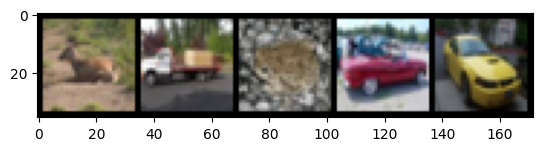

deer truck frog car car


In [3]:
cifar_train = datasets.CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10(root='./datasets', train=False, download=True, transform=transforms.ToTensor())
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Train size: {cifar_train.data.shape}")
print(f"Test size: {cifar_test.data.shape}")
print("mean:", cifar_train.data.mean(axis=(0, 1, 2)) / 255)
print("std:", cifar_train.data.std(axis=(0, 1, 2)) / 255)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainloader = DataLoader(cifar_train, batch_size=5, shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Image size: {images[0].shape}")

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(5)))

## Hyperparameters

In [4]:
BATCH_SIZE = 128 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 4)
EPOCHS = 30
NUM_CLASSES = len(classes)
set_seed(85)

Global seed set to 85


## Models

In [5]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Linear(1024, NUM_CLASSES)
        )
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, input):
        x = input
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = self.dropout(x)
        
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        
        out = self.fc(x)
        
        return out

def ResNet():
    resnet = torchvision.models.resnet50(pretrained=False, num_classes=NUM_CLASSES)
    resnet.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    resnet.maxpool = nn.Identity()
    return resnet

In [6]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model, use_resnet=False, len_cifar_train=50000, augmentation=False) -> None:
        super(ImageClassifier, self).__init__()
        
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        
        self.augmentation = augmentation
        
        indices = list(range(len_cifar_train))
        split = int(np.floor(len_cifar_train * 0.1))
        np.random.shuffle(indices)
        
        self.train_idx, self.val_idx = indices[split:], indices[:split]
        
    def train_dataloader(self):
        if self.augmentation:
            transformations = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)),
            ])
        else:
            transformations = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
            ])
        
        train_dataset = datasets.CIFAR10(root='./datasets', train=True, transform=transformations)
        train_sampler = SubsetRandomSampler(self.train_idx)
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            sampler=train_sampler,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        return train_loader

    def val_dataloader(self):
        transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
        ])
        
        val_dataset = datasets.CIFAR10(root='./datasets', train=True, transform=transformations)
        val_sampler = SubsetRandomSampler(self.val_idx)
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            sampler=val_sampler,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        return val_loader

    def test_dataloader(self):
        transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
        ])
        
        test_dataset = datasets.CIFAR10(root='./datasets', train=False, transform=transformations)
        test_loader = DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        return test_loader
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        output = self.model(images)
        
        loss = self.criterion(output, labels)
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        
        output = self.model(images)
        
        val_loss = self.criterion(output, labels)
        
        preds = output.argmax(dim=1, keepdim=True)
        corrects = preds.eq(labels.view_as(preds)).sum().item()
        accuracy = corrects / len(batch)
        
        result = {'val_loss': val_loss, 'corrects': corrects, 'num_labels': labels.shape[0]}
        self.log('val_loss', val_loss)
        return result

    def validation_epoch_end(self, outputs):
        val_losses = [output['val_loss'].item() for output in outputs]
        corrects = [output['corrects'] for output in outputs]
        num_labels = [output['num_labels'] for output in outputs]
        val_acc = np.sum(corrects) / np.sum(num_labels)
        
        self.log('val_loss_epoch', np.mean(val_losses), on_epoch=True, prog_bar=True)
        self.log('val_accuracy', val_acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        
        output = self.model(images)
        
        test_loss = self.criterion(output, labels)
        
        preds = output.argmax(dim=1, keepdim=True)
        corrects = preds.eq(labels.view_as(preds)).sum().item()
        
        result = {'test_loss': test_loss, 'corrects': corrects, 'num_labels': preds.shape[0]}
        return result

    def test_epoch_end(self, outputs) -> None:
        test_losses = [output['test_loss'].item() for output in outputs]
        corrects = [output['corrects'] for output in outputs]
        num_labels = [output['num_labels'] for output in outputs]
        test_acc = np.sum(corrects) / np.sum(num_labels)
        
        self.log('test_loss', np.mean(test_losses))
        self.log('test_acc', test_acc)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = {
            "scheduler": StepLR(
                optimizer,
                step_size=10,
                gamma=0.1
            ),
            "interval": "epoch",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [7]:
cnn = MyCNN()
summary(cnn, (3, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 32, 16, 16]          1,568
|    └─BatchNorm2d: 2-2                  [-1, 32, 16, 16]          64
|    └─ReLU: 2-3                         [-1, 32, 16, 16]          --
├─Sequential: 1-2                        [-1, 64, 8, 8]            --
|    └─Conv2d: 2-4                       [-1, 64, 8, 8]            32,832
|    └─BatchNorm2d: 2-5                  [-1, 64, 8, 8]            128
|    └─ReLU: 2-6                         [-1, 64, 8, 8]            --
├─Sequential: 1-3                        [-1, 128, 4, 4]           --
|    └─Conv2d: 2-7                       [-1, 128, 4, 4]           131,200
|    └─BatchNorm2d: 2-8                  [-1, 128, 4, 4]           256
|    └─ReLU: 2-9                         [-1, 128, 4, 4]           --
├─Sequential: 1-4                        [-1, 256, 4, 4]           --
|

In [8]:
cnn_classifier = ImageClassifier(model=cnn)
cnn_trainer = pl.Trainer(
    logger=pl_loggers.CSVLogger(
        save_dir='./models/cnn'
    ),
    callbacks=ModelCheckpoint(
        dirpath='./models/cnn',
        monitor='val_accuracy',
        filename='cifar10_{val_accuracy:.3f}',
        mode='max'
    ),
    gpus=1,
    max_epochs=EPOCHS,
)
cnn_trainer.fit(cnn_classifier)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MyCNN            | 1.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.086     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
cnn_result = cnn_trainer.test(cnn_classifier)

In [ ]:
resnet = ResNet()
summary(resnet, (3, 32, 32), verbose=0)

In [ ]:
resnet_classifier = ImageClassifier(model=resnet, use_resnet=True)
reesnet_trainer = pl.Trainer(
    logger=pl_loggers.CSVLogger(
        save_dir='./models/resnet'
    ),
    callbacks=ModelCheckpoint(
        dirpath='./models/resnet',
        monitor='val_accuracy',
        filename='cifar10_{val_accuracy:.3f}',
        mode='max'
    ),
    gpus=1,
    max_epochs=EPOCHS,
)
reesnet_trainer.fit(resnet_classifier)

In [ ]:
resnet18_result = reesnet_trainer.test(resnet_classifier)

In [ ]:
cnn_augmentation = MyCNN()
cnn_augmentation_classifier = ImageClassifier(model=cnn_augmentation, augmentation=True)
cnn_augmentation_trainer = pl.Trainer(
    logger=pl_loggers.CSVLogger(
        save_dir='./models/cnn_augmentation'
    ),
    callbacks=ModelCheckpoint(
        dirpath='./models/cnn_augmentation',
        monitor='val_accuracy',
        filename='cifar10_{val_accuracy:.3f}',
        mode='max'
    ),
    gpus=1,
    max_epochs=EPOCHS,
)
cnn_augmentation_trainer.fit(cnn_augmentation_classifier)

In [ ]:
cnn_augmentation_result = cnn_augmentation_trainer.test(cnn_augmentation_classifier)

### Analysis

## Variational Autoencoder

In [ ]:
LATENT_DIM = 1024
VAE_EPOCHS = 10
VAE_BATCH_SIZE = 32
VAE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_num_examples_to_generate = 16

In [ ]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        
        self.shape = shape
    
    def forward(self, x):
        return x.view(-1, self.shape[0], self.shape[1], self.shape[2])
    
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(16 * 8 * 8, latent_dim + latent_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 8 * 8),
            nn.ReLU(),
            Reshape((16, 8, 8)),
            nn.ConvTranspose2d(16, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 1, 1),
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = torch.split(x, LATENT_DIM, 1)
        return mean, logvar
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits

    def reparameterize(self, mean, logvar):
        eps = torch.randn(mean.shape).to(VAE_DEVICE)
        return eps * torch.exp(logvar * .5) + mean
    
    def sample(self, eps=None):
        if eps is None:
            eps = torch.randn(100, self.latent_dim)
        return self.decode(eps, apply_sigmoid=True)
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = torch.log(2. * torch.Tensor([np.pi]).to(VAE_DEVICE))
        if not isinstance(logvar, torch.Tensor):
            return torch.sum(-.5 * ((sample - mean) ** 2. * torch.exp(torch.Tensor([-logvar]).to(VAE_DEVICE)) + logvar + log2pi), dim=raxis)
        else:
            return torch.sum(-.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi), dim=raxis)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        return mean, logvar, z, x_logit


def compute_loss(model, x):
    mean, logvar, z, x_logit = model(x)
    cross_ent = F.binary_cross_entropy_with_logits(input=x_logit, target=x, reduce=False)
    logpx_z = -torch.sum(cross_ent, dim=(1, 2, 3))
    logpz = model.log_normal_pdf(z, 0., 0.)
    logqz_x = model.log_normal_pdf(z, mean, logvar)
    return -torch.mean(logpx_z * 0.7 + logpz * 0.15 - logqz_x * 0.15)

def train_step(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(VAE_DEVICE), labels.to(VAE_DEVICE)
        optimizer.zero_grad()
        loss = compute_loss(model, images)
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
    return train_losses

def test_step(model, test_loader):
    model.eval()
    test_losses = []
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(VAE_DEVICE), labels.to(VAE_DEVICE)
        loss = compute_loss(model, images)
        test_losses.append(loss.item())
    return np.mean(test_losses)

def generate_and_save_images(model, epoch, test_sample):
    model.eval()
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.transpose(predictions.detach().cpu().numpy()[i], (1, 2, 0)))
        plt.axis('off')
    plt.savefig('./vae_output/vae_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def show_test_sample(test_sample):
    fig = plt.figure(figsize=(4, 4))
    for i in range(test_sample.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.transpose(test_sample.detach().cpu().numpy()[i], (1, 2, 0)))
        plt.axis('off')
    plt.show()

In [ ]:
cvae = CVAE(LATENT_DIM).to(VAE_DEVICE)
summary(cvae, (3, 32, 32), verbose=0)

In [ ]:
transformations = transforms.Compose([
    transforms.ToTensor(),
])

vae_train_loader = DataLoader(datasets.CIFAR10(root='./datasets', train=True, transform=transformations), batch_size=VAE_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
vae_test_loader = DataLoader(datasets.CIFAR10(root='./datasets', train=False, transform=transformations), batch_size=VAE_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)

In [ ]:
assert VAE_BATCH_SIZE >= vae_num_examples_to_generate
for batch_idx, (images, labels) in enumerate(vae_test_loader):
    test_sample = images[0:vae_num_examples_to_generate].to(VAE_DEVICE)
    break

In [ ]:
test_sample.shape, test_sample.device

In [ ]:
generate_and_save_images(cvae, 0, test_sample)

In [ ]:
optimizer = optim.Adam(cvae.parameters(), lr=0.001)
for epoch in range(1, VAE_EPOCHS + 1):
    start_time = time.time()
    train_losses = train_step(cvae, vae_train_loader, optimizer)
    end_time = time.time()
    elbo = -test_step(cvae, vae_test_loader)
    display.clear_output(wait=False)
    print(f"Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}")
    generate_and_save_images(cvae, epoch, test_sample)

In [ ]:
show_test_sample(test_sample)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')

## GAN

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(datasets.CIFAR10(root='./datasets', train=True, transform=transformations), batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)
print(summary(netG, (100, 1, 1), verbose=0))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print(summary(netD, (3, 32, 32), verbose=0))

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    display.clear_output(wait=True)
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
        iters += 1

    torchvision.utils.save_image(fake, paddig=2, normalize=True, fp='./gan_output/gan_image_at_epoch_{:04d}.jpg'.format(epoch))

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

display.HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()